In [ ]:
import math
from dataclasses import dataclass

import torch
import torch.nn as nn
from torch.nn import functional as F

from transformers import AutoModelForCausalLM, AutoTokenizer


In [ ]:
# Choose device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [ ]:
@dataclass
class Config:
    model_name: str = "google/gemma-2-2b-it"

    # Base prompt whose internal state we want to imitate
    base_prompt: str = "Talk about cats."

    # Starting point for the *other* prompt (must be different text)
    seed_prompt: str = "Write a short poem about the ocean."

    # Which layer's activations to match.
    # -1 = final layer; 0 = embedding layer; 1..n_layers-1 = internal layers
    target_layer_index: int = -1

    # How long prompts are (in tokens). We’ll crop/pad both to this length.
    seq_len: int | None = None  # if None, use length of base prompt tokens

    # Optimization hyperparameters
    num_steps: int = 400
    lr: float = 5e-2
    weight_decay: float = 1e-4

    # How often to log during optimization
    log_every: int = 50

    # Loss type: "mse" or "cosine"
    loss_type: str = "mse"

    # L2 regularization towards the initial seed embeddings
    lambda_reg: float = 1e-3

    # Random seed
    seed: int = 0

cfg = Config()


In [ ]:
torch.manual_seed(cfg.seed)

tokenizer = AutoTokenizer.from_pretrained(cfg.model_name)
model = AutoModelForCausalLM.from_pretrained(
    cfg.model_name,
    torch_dtype=torch.bfloat16 if torch.cuda.is_available() else torch.float32,
    device_map="auto" if torch.cuda.is_available() else None,
)
model.eval()
for p in model.parameters():
    p.requires_grad = False

print("Model loaded.")


`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Model loaded.


In [ ]:
def encode_fixed_length(text: str, seq_len: int | None = None):
    """Tokenize a string and return input_ids of fixed length."""
    tokens = tokenizer(
        text,
        add_special_tokens=True,
        return_tensors="pt",
    )["input_ids"][0]  # shape: [L]

    if seq_len is None:
        seq_len = tokens.shape[0]

    # Pad or crop to seq_len
    eos_id = tokenizer.eos_token_id
    if tokens.shape[0] < seq_len:
        pad = torch.full((seq_len - tokens.shape[0],), eos_id, dtype=tokens.dtype)
        tokens = torch.cat([tokens, pad], dim=0)
    elif tokens.shape[0] > seq_len:
        tokens = tokens[:seq_len]

    return tokens, seq_len


In [ ]:
def get_hidden_flat(
    input_ids: torch.Tensor,
    layer_index: int,
) -> torch.Tensor:
    """
    Run the model on input_ids and return the hidden states at a given layer,
    flattened across positions.

    input_ids: [seq_len]
    layer_index: like cfg.target_layer_index (can be negative).
    Returns: [hidden_dim * seq_len] float tensor on device=cpu (for stability)
    """
    assert input_ids.ndim == 1
    input_ids = input_ids.unsqueeze(0).to(device)  # [1, seq_len]
    attention_mask = torch.ones_like(input_ids, device=device)

    with torch.no_grad():
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            output_hidden_states=True,
            use_cache=False,
        )

    hidden_states = outputs.hidden_states  # length = n_layers + 1
    h = hidden_states[layer_index]  # [1, seq_len, d_model]
    h = h[0]  # [seq_len, d_model]
    return h.flatten().detach().cpu()  # [seq_len * d_model]


In [ ]:
# Decide sequence length
base_ids_raw = tokenizer(cfg.base_prompt, add_special_tokens=True, return_tensors="pt")["input_ids"][0]
if cfg.seq_len is None:
    cfg.seq_len = base_ids_raw.shape[0]

print("Using seq_len =", cfg.seq_len)

base_ids, _ = encode_fixed_length(cfg.base_prompt, cfg.seq_len)
seed_ids, _ = encode_fixed_length(cfg.seed_prompt, cfg.seq_len)

print("Base prompt tokens:", base_ids.tolist())
print("Seed prompt tokens:", seed_ids.tolist())
print("Base prompt text:", tokenizer.decode(base_ids))
print("Seed prompt text:", tokenizer.decode(seed_ids))


Using seq_len = 5
Base prompt tokens: [2, 27586, 1105, 19493, 235265]
Seed prompt tokens: [2, 5559, 476, 3309, 19592]
Base prompt text: <bos>Talk about cats.
Seed prompt text: <bos>Write a short poem


In [ ]:
target_vec = get_hidden_flat(base_ids, cfg.target_layer_index)
print("Target activation vector shape:", target_vec.shape)


Target activation vector shape: torch.Size([11520])


In [ ]:
embed_layer = model.get_input_embeddings()  # nn.Embedding
d_model = embed_layer.weight.shape[1]

def ids_to_embeds(ids: torch.Tensor) -> torch.Tensor:
    """Convert [seq_len] token IDs to [1, seq_len, d_model] embeddings."""
    return embed_layer(ids.to(device)).unsqueeze(0)  # [1, seq_len, d_model]

with torch.no_grad():
    seed_embeds_init = ids_to_embeds(seed_ids)  # [1, seq_len, d_model]

# Trainable embeddings
soft_embeds = nn.Parameter(seed_embeds_init.clone())

optimizer = torch.optim.AdamW(
    [soft_embeds],
    lr=cfg.lr,
    weight_decay=cfg.weight_decay,
)


In [ ]:
target_vec_device = target_vec.to(device)

def activation_loss(soft_embeds: torch.Tensor) -> torch.Tensor:
    """
    Compute loss between hidden states of soft_embeds and target_vec.
    soft_embeds: [1, seq_len, d_model], requires_grad=True
    """
    seq_len = soft_embeds.shape[1]
    attention_mask = torch.ones((1, seq_len), dtype=torch.long, device=device)

    outputs = model(
        inputs_embeds=soft_embeds.to(model.dtype),
        attention_mask=attention_mask,
        output_hidden_states=True,
        use_cache=False,
    )

    hidden_states = outputs.hidden_states
    h = hidden_states[cfg.target_layer_index][0]  # [seq_len, d_model]
    h_flat = h.flatten()

    if cfg.loss_type == "mse":
        act_loss = F.mse_loss(h_flat, target_vec_device)
    elif cfg.loss_type == "cosine":
        act_loss = 1.0 - F.cosine_similarity(h_flat, target_vec_device, dim=0)
    else:
        raise ValueError(f"Unknown loss_type: {cfg.loss_type}")

    # Regularization towards initial embeddings
    reg = F.mse_loss(soft_embeds, seed_embeds_init.to(soft_embeds.device))
    total = act_loss + cfg.lambda_reg * reg
    return total, act_loss.detach(), reg.detach(), h_flat.detach()


In [ ]:
history = {
    "total": [],
    "act": [],
    "reg": [],
    "cosine_to_target": [],
}

for step in range(1, cfg.num_steps + 1):
    optimizer.zero_grad()
    loss, act_loss, reg_loss, h_flat = activation_loss(soft_embeds)
    loss.backward()
    optimizer.step()

    # Track cosine similarity between current activations and target
    cos_sim = F.cosine_similarity(h_flat, target_vec_device, dim=0).item()

    history["total"].append(loss.item())
    history["act"].append(act_loss.item())
    history["reg"].append(reg_loss.item())
    history["cosine_to_target"].append(cos_sim)

    if step % cfg.log_every == 0 or step == 1 or step == cfg.num_steps:
        print(
            f"Step {step:4d} | total={loss.item():.4f} | "
            f"act={act_loss.item():.4f} | reg={reg_loss.item():.4f} | "
            f"cos={cos_sim:.4f}"
        )


Step    1 | total=3.2812 | act=3.2812 | reg=0.0000 | cos=0.7031
Step   50 | total=0.8047 | act=0.8047 | reg=0.0723 | cos=0.9297
Step  100 | total=0.3262 | act=0.3262 | reg=0.0688 | cos=0.9727
Step  150 | total=0.1865 | act=0.1865 | reg=0.0659 | cos=0.9805
Step  200 | total=0.1250 | act=0.1250 | reg=0.0640 | cos=0.9883
Step  250 | total=0.0942 | act=0.0942 | reg=0.0630 | cos=0.9922
Step  300 | total=0.0747 | act=0.0747 | reg=0.0620 | cos=0.9922
Step  350 | total=0.0713 | act=0.0713 | reg=0.0613 | cos=0.9883
Step  400 | total=0.0566 | act=0.0566 | reg=0.0608 | cos=0.9922


In [ ]:
@torch.no_grad()
def project_embeds_to_tokens(embeds: torch.Tensor) -> torch.Tensor:
    """
    embeds: [1, seq_len, d_model] (float)
    Returns: token_ids [seq_len] via nearest-neighbor in embedding space.
    """
    embeds = embeds[0]  # [seq_len, d_model]
    # embedding weight: [vocab_size, d_model]
    vocab_embeds = embed_layer.weight  # [V, d_model]

    # cosine similarity is often more stable than L2
    # [seq_len, V]
    sims = F.linear(F.normalize(embeds.float(), dim=-1), F.normalize(vocab_embeds.float(), dim=-1))

    token_ids = sims.argmax(dim=-1)  # [seq_len]
    return token_ids.cpu()

soft_embeds_opt = soft_embeds.detach().to(device)
opt_ids = project_embeds_to_tokens(soft_embeds_opt)
opt_text = tokenizer.decode(opt_ids, skip_special_tokens=False)

print("=== Original base prompt ===")
print(cfg.base_prompt)
print("\n=== Seed prompt (initial) ===")
print(cfg.seed_prompt)
print("\n=== Optimized discrete prompt (decoded) ===")
print(opt_text)


=== Original base prompt ===
Talk about cats.

=== Seed prompt (initial) ===
Write a short poem about the ocean.

=== Optimized discrete prompt (decoded) ===
<bos>I a short发言


In [ ]:
opt_vec = get_hidden_flat(opt_ids, cfg.target_layer_index)

with torch.no_grad():
    mse = F.mse_loss(opt_vec.to(device), target_vec_device).item()
    cos = F.cosine_similarity(opt_vec.to(device), target_vec_device, dim=0).item()

print("Activation distance (MSE) between base and optimized discrete prompt:", mse)
print("Activation cosine similarity between base and optimized discrete prompt:", cos)


Activation distance (MSE) between base and optimized discrete prompt: 13.9375
Activation cosine similarity between base and optimized discrete prompt: 0.337890625


In [ ]:
def generate_from_prompt(text: str, max_new_tokens: int = 64):
    inputs = tokenizer(text, return_tensors="pt").to(device)
    with torch.no_grad():
        out = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=False,
        )
    return tokenizer.decode(out[0], skip_special_tokens=True)

print("\n=== Model output on base prompt ===")
print(generate_from_prompt(cfg.base_prompt))

print("\n=== Model output on optimized discrete prompt ===")
print(generate_from_prompt(opt_text))



=== Model output on base prompt ===
Talk about cats.

Cats are fascinating creatures. They are known for their independence, grace, and playful nature. 

Here are some interesting facts about cats:

* **Cats have excellent night vision.** Their eyes have a special reflective layer that allows them to see in low light conditions.
* **Cats have a third eyelid called

=== Model output on optimized discrete prompt ===
I a short发言稿，请写出以下内容：

* **引言：** 
* **主要内容：**
    * 阐述“互联网时代”的特征和意义。
    * 阐述“互联网时代”对教育的意义。
    * 阐述“互联网时代”对社会


In [ ]:
print(f">{opt_text}<")

><bos>I a short发言<


In [2]:
!pip install matplotlib

  Using cached matplotlib-3.10.8-cp313-cp313-win_amd64.whl.metadata (52 kB)
  Using cached contourpy-1.3.3-cp313-cp313-win_amd64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.61.1-cp313-cp313-win_amd64.whl.metadata (116 kB)
  Using cached kiwisolver-1.4.9-cp313-cp313-win_amd64.whl.metadata (6.4 kB)
  Using cached pillow-12.0.0-cp313-cp313-win_amd64.whl.metadata (9.0 kB)
  Using cached pyparsing-3.2.5-py3-none-any.whl.metadata (5.0 kB)
Using cached matplotlib-3.10.8-cp313-cp313-win_amd64.whl (8.1 MB)
Using cached contourpy-1.3.3-cp313-cp313-win_amd64.whl (226 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
Using cached fonttools-4.61.1-cp313-cp313-win_amd64.whl (2.3 MB)
Using cached kiwisolver-1.4.9-cp313-cp313-win_amd64.whl (73 kB)
Using cached pillow-12.0.0-cp313-cp313-win_amd64.whl (7.0 MB)
Using cached pyparsing-3.2.5-py3-none-any.whl (113 kB)



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


C:\Users\awebb\AppData\Local\Temp\ipykernel_36416\2623157814.py:16: MatplotlibDeprecationWarning: Passing the notch parameter of boxplot() positionally is deprecated since Matplotlib 3.10; the parameter will become keyword-only in 3.12.
  plt.boxplot(crossentropy, False, sym='rs', vert=False, whis=0.75, positions=[0])


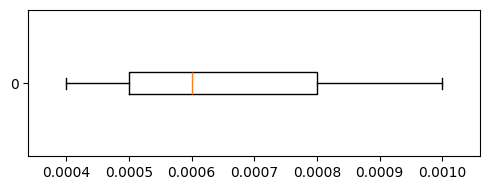

In [41]:
import matplotlib.pyplot as plt

crossentropy = [
    0.0008,
    0.0005,
    0.0004,
    0.0007,
    0.0008,
    0.0005,
    0.0010,
    0.0005, 
]

fig = plt.figure(figsize=(5, 2), dpi=100)

plt.boxplot(crossentropy, False, sym='rs', vert=False, whis=0.75, positions=[0])
plt.margins(0.1, 0.1)
plt.tight_layout()
plt.show()
